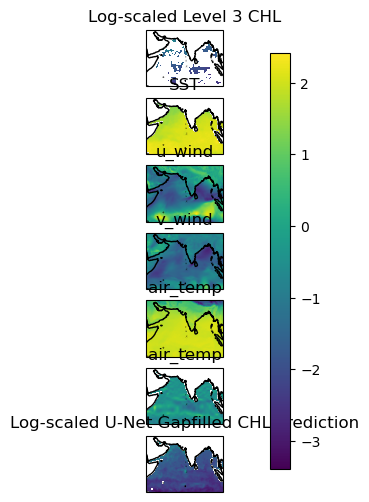

In [5]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Load the saved Zarr data
zarr_path = '~/shared-public/mind_the_chl_gap/U-Net_with_CHL_pred.zarr'
zarr_ds = xr.open_zarr(zarr_path)['gapfree_pred']

# Select the date you want to plot
date_to_plot = '2022-01-01'  # Replace with the desired date
zarr_date = zarr_ds.sel(time=date_to_plot)

# Load the Level 3 CHL data
level3_path = '~/shared-public/mind_the_chl_gap/IO.zarr'
level3_ds = xr.open_zarr(level3_path)
level3_chl = level3_ds['CHL_cmes-level3'].sel(time=date_to_plot)
sst = level3_ds['sst'].sel(time=date_to_plot)
u_wind = level3_ds['u_wind'].sel(time=date_to_plot)
v_wind = level3_ds['v_wind'].sel(time=date_to_plot)
air_temp = level3_ds['air_temp'].sel(time=date_to_plot)
ug_curr = level3_ds['ug_curr'].sel(time=date_to_plot)
# Plot the data
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the log-scaled Level 3 CHL data
ax = axes[0]
level3_chl_log = np.log(level3_chl.where(~np.isnan(level3_chl), np.nan))
im = ax.imshow(level3_chl_log, vmin=np.nanmin(level3_chl_log), vmax=np.nanmax(level3_chl_log), extent=(42, 101.75, -11.75, 32), origin='upper', transform=ccrs.PlateCarree())
ax.set_title('Log-scaled Level 3 CHL')
ax.add_feature(cfeature.COASTLINE)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax = axes[1]
im = ax.imshow(sst, vmin=np.nanmin(sst), vmax=np.nanmax(sst), extent=(42, 101.75, -11.75, 32), origin='upper', transform=ccrs.PlateCarree())
ax.set_title('SST')
ax.add_feature(cfeature.COASTLINE)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax = axes[2]
im = ax.imshow(u_wind, vmin=np.nanmin(u_wind), vmax=np.nanmax(u_wind), extent=(42, 101.75, -11.75, 32), origin='upper', transform=ccrs.PlateCarree())
ax.set_title('u_wind')
ax.add_feature(cfeature.COASTLINE)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax = axes[3]
im = ax.imshow(v_wind, vmin=np.nanmin(v_wind), vmax=np.nanmax(v_wind), extent=(42, 101.75, -11.75, 32), origin='upper', transform=ccrs.PlateCarree())
ax.set_title('v_wind')
ax.add_feature(cfeature.COASTLINE)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax = axes[4]
im = ax.imshow(air_temp, vmin=np.nanmin(air_temp), vmax=np.nanmax(air_temp), extent=(42, 101.75, -11.75, 32), origin='upper', transform=ccrs.PlateCarree())
ax.set_title('air_temp')
ax.add_feature(cfeature.COASTLINE)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax = axes[5]
im = ax.imshow(ug_curr, vmin=np.nanmin(ug_curr), vmax=np.nanmax(ug_curr), extent=(42, 101.75, -11.75, 32), origin='upper', transform=ccrs.PlateCarree())
ax.set_title('air_temp')
ax.add_feature(cfeature.COASTLINE)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax = axes[6]
gapfill_chl_log = zarr_date
im = ax.imshow(gapfill_chl_log, vmin=np.nanmin(gapfill_chl_log), vmax=np.nanmax(gapfill_chl_log), extent=(42, 101.75, -11.75, 32), origin='upper', transform=ccrs.PlateCarree())
ax.set_title('Log-scaled U-Net Gapfilled CHL Prediction')
ax.add_feature(cfeature.COASTLINE)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

fig.colorbar(im, ax=axes.ravel().tolist(), location='right', shrink=0.9)
plt.show()

In [6]:
pip install deepxde

Note: you may need to restart the kernel to use updated packages.


In [6]:
import numpy as np
import xarray as xr
import os
os.environ["DDEBACKEND"] = "pytorch"
import deepxde as dde
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from tqdm import tqdm
import torch

print("Starting data loading process...")

# Load the data
zarr_path = '~/shared-public/mind_the_chl_gap/U-Net_with_CHL_pred.zarr'
zarr_ds = xr.open_zarr(zarr_path)['gapfree_pred']

level3_path = '~/shared-public/mind_the_chl_gap/IO.zarr'
level3_ds = xr.open_zarr(level3_path)

# Select data for 2019-2021
time_slice = slice('2019-01-01', '2021-12-31')
zarr_ds = zarr_ds.sel(time=time_slice)
level3_ds = level3_ds.sel(time=time_slice)

print("Data loaded. Preparing input and output data...")

# Prepare the input data (v)
variables = ['CHL_cmes-level3', 'sst', 'u_wind', 'v_wind', 'air_temp', 'ug_curr']
input_data = []

for var in tqdm(variables, desc="Processing variables"):
    data = level3_ds[var].values
    data = np.log(data) if var == 'CHL_cmes-level3' else data
    input_data.append(data)

v = np.stack(input_data, axis=-1)

# Prepare the output data (u)
u = zarr_ds.values

print("Reshaping data...")

# Modify the data preparation part
v = v.reshape(-1, v.shape[-1])  # (num_points, num_variables)
u = u.reshape(-1)  # (num_points,)

# Create spatial points (you may need to adjust this based on your specific problem)
x = np.linspace(0, 1, v.shape[0]).reshape(-1, 1)
x = torch.tensor(x, dtype=torch.float32)

# Prepare the data for DeepONet
n_train = int(0.8 * len(u))
X_train = (v[:n_train], x[:n_train])
y_train = u[:n_train]
X_test = (v[n_train:], x[n_train:])
y_test = u[n_train:]

# Set up the data
data = dde.data.Triple(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

# Adjust the DeepONet architecture
m = v.shape[1]  # number of input variables
dim_x = 1  # dimension of spatial input

net = dde.nn.pytorch.DeepONet(
    [m, 64, 64],  # branch net
    [dim_x, 64, 64],  # trunk net
    "relu",
    "Glorot normal",
)

# Create a custom loss function
def custom_loss(inputs, outputs, targets):
    return torch.mean((outputs - targets)**2)

# Create the model
model = dde.Model(data, net)
print(v.dtype)
print(x.dtype)
print(u.dtype)

# Compile the model
model.compile("adam", lr=0.001, loss=custom_loss, metrics=["mean l2 relative error"])

print("Training the model...")

# Train the model
losshistory, train_state = model.train(iterations=10000, batch_size=32) 

print("Making predictions...")

# Make predictions
y_pred = model.predict(X_test)

# Reshape the predictions back to the original shape
y_pred = y_pred.reshape(zarr_ds.shape[1:])

print("Visualizing results...")

# Visualize the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# True gap-filled CHL
im1 = ax1.imshow(zarr_ds.isel(time=0), extent=(42, 101.75, -11.75, 32), origin='upper', transform=ccrs.PlateCarree())
ax1.set_title('True Gap-filled CHL')
ax1.add_feature(cfeature.COASTLINE)
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
fig.colorbar(im1, ax=ax1)

# Predicted gap-filled CHL
im2 = ax2.imshow(y_pred, extent=(42, 101.75, -11.75, 32), origin='upper', transform=ccrs.PlateCarree())
ax2.set_title('Predicted Gap-filled CHL')
ax2.add_feature(cfeature.COASTLINE)
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
fig.colorbar(im2, ax=ax2)

plt.show()

print("Process completed.")

Starting data loading process...
Data loaded. Preparing input and output data...


Processing variables: 100%|██████████| 6/6 [00:01<00:00,  5.35it/s]


Reshaping data...
float32
torch.float32
float32
Compiling model...
'compile' took 0.000145 s

Training the model...
Training model...



TypeError: custom_loss() missing 1 required positional argument: 'targets'

In [16]:
def plot_gapfill(zarr_stdized, zarr_label, model, date_to_predict):
    mean_std = np.load(f'data/{zarr_label}.npy',allow_pickle='TRUE').item()
    mean, std = mean_std['CHL'][0], mean_std['CHL'][1]
    zarr_date = zarr_stdized.sel(time=date_to_predict)
    X = []
    X_vars = list(zarr_stdized.keys())
    X_vars.remove('CHL')
    X_vars[X_vars.index('masked_CHL')] = 'CHL'
    X_vars[X_vars.index('real_cloud_flag')] = 'a'
    X_vars[X_vars.index('fake_cloud_flag')] = 'real_cloud_flag'
    X_vars[X_vars.index('a')] = 'fake_cloud_flag'
    
    for var in X_vars:
        var = zarr_date[var].to_numpy()
        X.append(np.where(np.isnan(var), 0.0, var))
    valid_CHL_ind = X_vars.index('valid_CHL_flag')
    X[valid_CHL_ind] = np.where(X[X_vars.index('fake_cloud_flag')] == 1, 1, X[valid_CHL_ind])
    X[X_vars.index('fake_cloud_flag')] = np.zeros(X[0].shape)
    X_masked_CHL = np.log(zarr_ds.sel(time=date_to_predict)['CHL_cmes-level3'].to_numpy())
    X_masked_CHL = (X_masked_CHL - mean_std['masked_CHL'][0]) / mean_std['masked_CHL'][1]
    X_vars[X_vars.index('CHL')] = X_masked_CHL

    X = np.array(X)
    X = np.moveaxis(X, 0, -1)
    X = torch.from_numpy(X)[None, ...]

    true_CHL = np.log(zarr_ds.sel(time=date_to_predict)['CHL_cmes-gapfree'].to_numpy())
    masked_CHL = np.log(zarr_ds.sel(time=date_to_predict)['CHL_cmes-level3'].to_numpy())
    predicted_CHL = model(X).detach().numpy()[0, :, :, 0]
    predicted_CHL = unstdize(predicted_CHL, mean, std)
    predicted_CHL = np.where(np.isnan(true_CHL), np.nan, predicted_CHL)
    log_diff = true_CHL - predicted_CHL
    diff = np.exp(true_CHL) - np.exp(predicted_CHL)

    vmax = np.nanmax((true_CHL, predicted_CHL))
    vmin = np.nanmin((true_CHL, predicted_CHL))

    extent = [42, 101.75, -11.75, 32]
plot_gapfill(zarr_label, model, model_name, date)

NameError: name 'zarr_label' is not defined